# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [35]:
# Functions

# Probability Functions

def prob_hold_to_love(p):
    """Probability server holds at love."""
    return p**4

def prob_hold_to_15(p):
    """Probability server holds to 15."""
    q = 1-p
    return 4*(p**4)*q

def prob_hold_to_30(p):
    """Probability server holds to 30."""
    q = 1-p
    return 10*(p**4)*(q**2)

def prob_get_to_deuce(p):
    """Probability game gets to deuce at least once."""
    q = 1-p
    return 20*(p**3)*(q**3)

def prob_hold_via_deuce(p):
    """Probability server holds from deuce."""
    q = 1-p
    d = (p**2) / (1 - 2*p*q)
    return d*prob_get_to_deuce(p)

def prob_hold(p):
    """Probability server holds."""
    return (
        prob_hold_to_love(p) +
        prob_hold_to_15(p) + 
        prob_hold_to_30(p) + 
        prob_hold_via_deuce(p)
    )

# working on probability of winning a series of games
def prob_six_zero(ps):
    """Probability server wins 6-0."""
    return ps**6

def prob_six_one(ps):
    """Probability server wins 6-1."""
    qs = 1-ps
    return 6*(ps**6)*qs

def prob_six_two(ps):
    """Probability server wins 6-2."""
    qs = 1-ps
    return 21*(ps**6)*(qs**2)

def prob_six_three(ps):
    """Probability server wins 6-3."""
    qs = 1-ps
    return 56*(ps**6)*(qs**3)

def prob_six_four(ps):
    """Probability server wins 6-4."""
    qs = 1-ps
    return 126*(ps**6)*(qs**4)

def prob_seven_five(ps):
    """Probability server wins 7-5."""
    qs = 1-ps
    return 42*(ps**7)*(qs**5)

def prob_tiebreaker(ps):
    """Probability server wins 7-6."""
    qs = 1-ps
    return 924*(ps**7)*(qs**6)

def prob_win_set(ps):
    """Probability server holds."""
    return (
        prob_six_zero(ps) +
        prob_six_one(ps) + 
        prob_six_two(ps) + 
        prob_six_three(ps) +
        prob_six_four(ps) +
        prob_seven_five(ps) +
        prob_tiebreaker(ps)
    )

# Calculate the probability of winning a match
def prob_three_zero(pm):
    """Probability player1 wins 3-0."""
    qm = 1-pm
    return pm**3

def prob_three_one(pm):
    """Probability player1 wins 3-1."""
    qm = 1-pm
    return 3*(pm**3)*qm

def prob_three_two(pm):
    """Probability player1 wins 3-2."""
    qm = 1-pm
    return 6*(pm**3)*(qm**2)

def prob_win_match(pm):
    """Probability server holds."""
    return (
        prob_three_zero(pm) +
        prob_three_one(pm) + 
        prob_three_two(pm) 
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player):
    # n = number of sets won
    n = 0
    x = 1.5

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1

        if (n > 0):
            probability_array[index] = (((x**n)-1)/(x**n) + (1/(x**n))*probability_array[index])

        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player):
    array = []

    # unforced error total
    n = 0
    x = 1.001


    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

        if (n > 0):
            array.append (((x**n) - 1) / (x**n) + (1 / (x**n)) * momentum_array[index])
        
    print("n: ", n)
    print("x: ", x)
    return array

In [57]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase

class MarkovChain:
    def __init__(self, file, match_to_examine):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

    # raw_data = pd.read_csv(file)
    # match = raw_data[raw_data['match_id'] == match_to_examine]
    
    # player1_name = match['player1'].values[0]
    # player2_name = match['player2'].values[0]

    # max_length = 0

    # p1_momentum = []
    # p2_momentum = []

    # 1 - Get serve probabilities
    def get_serve_probabilities(self):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        print("Probability of winning a serve")
        print(p1_probability)
        print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability, len(p2_probability)))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        print("Probability of winning the game")
        print(pg1_array)
        print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        print("Probability of winning the set")

        print(ps1_array)
        print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        print("Probability of winning the match")

        print(pm1_array)
        print(pm2_array)

        return pm1_array, pm2_array
    
    def update_momentum(self, pm1_array, pm2_array):    
        p1_momentum = modify_momentum(self.match,  pm1_array, 1)
        p2_momentum = modify_momentum(self.match, pm2_array, 2)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2)

        return p1_momentum1, p2_momentum2
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self):
        # Find who was performing better before sets 3 and 5
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            if index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            if index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_5_pred = self.player2_name
                    print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")


        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        print(winner, "won the game")

        if winner == set_4_pred:
            print("set 3 prediction is correct")
        else:
            print("set 3 prediction is wrong")

        if winner == set_4_pred:
            print("set 4 prediction is correct")
        else:
            print("set 4 prediction is wrong")

        if winner == set_5_pred:
            print("set 5 prediction is correct")
        else:
            print("set 5 prediction is wrong")

    def train(self):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities())))) # 1
        
    train()
    graph_momentum()
    prediction()


NameError: name 'update_momentum' is not defined

Probability of winning a serve
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.25, 0.4, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2857142857142857, 0.375, 0.3333333333333333, 0.3, 0.36363636363636365, 0.4166666666666667, 0.38461538461538464, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.4, 0.4375, 0.4117647058823529, 0.3888888888888889, 0.42105263157894735, 0.45, 0.45, 0.45, 0.45, 0.45, 0.47619047619047616, 0.45454545454545453, 0.4782608695652174, 0.5, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.5, 0.5185185185185185, 0.5357142857142857, 0.5172413793103449, 0.5333333333333333, 0.5161290322580645, 0.5, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.484848484848484

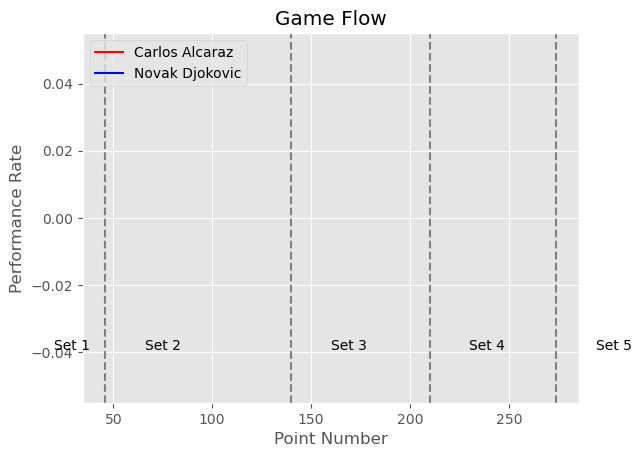

IndexError: list index out of range

In [56]:
MATCH_TO_EXAMINE = '2023-wimbledon-1701'
FILE = '2023-wimbledon-data.csv'

model(FILE, MATCH_TO_EXAMINE)

In [39]:
# 1 - Get serve probabilities

p1_probability = get_serve_probability(alcaraz_match, 1)
p2_probability = get_serve_probability(alcaraz_match, 2)

print("Probability of winning a serve")
print(p1_probability)
print(p2_probability)

Probability of winning a serve
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.25, 0.4, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2857142857142857, 0.375, 0.3333333333333333, 0.3, 0.36363636363636365, 0.4166666666666667, 0.38461538461538464, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.35714285714285715, 0.4, 0.4375, 0.4117647058823529, 0.3888888888888889, 0.42105263157894735, 0.45, 0.45, 0.45, 0.45, 0.45, 0.47619047619047616, 0.45454545454545453, 0.4782608695652174, 0.5, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.5, 0.5185185185185185, 0.5357142857142857, 0.5172413793103449, 0.5333333333333333, 0.5161290322580645, 0.5, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.48484848484848486, 0.484848484848484

In [40]:
#  2 - Get probability of winning the game

get_game_probabilities(p1_probability, p2_probability)

Probability of winning the game
[0.0, 0.25, 0.4279835390946502, 0.25, 0.36786461538461535, 0.25, 0.1633783542571548, 0.25, 0.18182171152606202, 0.1321353846153846, 0.1321353846153846, 0.1321353846153846, 0.1321353846153846, 0.1575260096153846, 0.26427076923076925, 0.2041518455207344, 0.16891839784553547, 0.2220417031614948, 0.27436307760143935, 0.2353948151625046, 0.2041518455207344, 0.17932703650277626, 0.148886027533504, 0.21462115119485292, 0.17932703650277626, 0.15691609283880575, 0.20421251253761216, 0.2573358178535715, 0.2238653804175212, 0.19852369322249508, 0.17884756402749158, 0.16322957853041847, 0.19242812173690793, 0.17639079537736213, 0.16322957853041847, 0.2041518455207345, 0.2456868628453288, 0.2166777181007703, 0.19280398233570734, 0.22690910191587224, 0.26044220966772613, 0.24960971564923135, 0.240660230514453, 0.2332347368874409, 0.22704559044387768, 0.25895887781896576, 0.23249870766744146, 0.2615227971887655, 0.2886198416815014, 0.31355996307702855, 0.32925640996535

In [9]:
# 3 - Get probability of winning the set.

ps1_array = []
ps2_array = []

for index in range(max_length):
    ps1_array.append(prob_win_set(pg1_array[index]))
    ps2_array.append(prob_win_set(pg2_array[index]))

print("Probability of winning the set")

print(ps1_array)
print(ps2_array)

Probability of winning the set
[0.0, 0.03037339448928833, 0.30868245521602167, 0.03037339448928833, 0.17519694612356027, 0.03037339448928833, 0.0032296092442346035, 0.03037339448928833, 0.005791646213951558, 0.0009847063709745463, 0.0009847063709745463, 0.0009847063709745463, 0.0009847063709745463, 0.0026398747392018035, 0.039896690385878765, 0.010752225104022427, 0.003879254606162386, 0.016662362828909684, 0.047801643954976575, 0.022458089363117068, 0.010752225104022427, 0.005374246508562459, 0.001928505076793857, 0.013972259684199372, 0.005374246508562459, 0.0025836971571478926, 0.010769077469750006, 0.03503564081062912, 0.017379209196056074, 0.009274428383796277, 0.005296784832528711, 0.003213432559491229, 0.007855354365925191, 0.004913446119131028, 0.003213432559491229, 0.01075222510402246, 0.027852345387572544, 0.0146822865116272, 0.007937674022424901, 0.018626764893273216, 0.03715724242329929, 0.03013869411978852, 0.02511119491366752, 0.021431961643688262, 0.01868423269551381, 0.

In [10]:
# 4 - Get probability of winning the match

pm1_array = []
pm2_array = []

for index in range(max_length):
    pm1_array.append(prob_win_match(ps1_array[index]))
    pm2_array.append(prob_win_match(ps2_array[index]))

print("Probability of winning the match")

print(pm1_array)
print(pm2_array)

Probability of winning the match
[0.0, 0.0002675964687201091, 0.17475512295089793, 0.0002675964687201091, 0.040633440172013244, 0.0002675964687201091, 3.352306003565935e-07, 0.0002675964687201091, 1.9258634349779624e-06, 9.534074546853313e-09, 9.534074546853313e-09, 9.534074546853313e-09, 9.534074546853313e-09, 1.8324352837724632e-07, 0.0005976556163160695, 1.2231060496794237e-05, 5.803824991673417e-07, 4.511193397439144e-05, 0.0010154455235657652, 0.00010948942252133984, 1.2231060496794237e-05, 1.539732015107095e-06, 7.151632710387533e-08, 2.670871863955175e-05, 1.539732015107095e-06, 1.7180672929862495e-07, 1.2288348290439561e-05, 0.0004077766719225202, 5.113274503413494e-05, 7.866834546505206e-06, 1.4742802096308817e-06, 3.3022644378067535e-07, 4.790335397889017e-06, 1.1774765153312473e-06, 3.3022644378067535e-07, 1.223106049679435e-05, 0.00020713911887930772, 3.0957577439277324e-05, 4.941905451509755e-06, 6.283452014736274e-05, 0.00048484705223001887, 0.0002615350345378311, 0.00015

In [32]:
p1_momentum = modify_momentum(alcaraz_match,  pm1_array, 1)
p2_momentum = modify_momentum(alcaraz_match, pm2_array, 2)

print(p1_momentum)
print(p2_momentum)

print(len(p1_momentum))

p1_momentum1 = modify_momentum_err(alcaraz_match, p1_momentum, 1)
p2_momentum2 = modify_momentum_err(alcaraz_match, p2_momentum, 2)

[0.0, 0.0002675964687201091, 0.17475512295089793, 0.0002675964687201091, 0.040633440172013244, 0.0002675964687201091, 3.352306003565935e-07, 0.0002675964687201091, 1.9258634349779624e-06, 9.534074546853313e-09, 9.534074546853313e-09, 9.534074546853313e-09, 9.534074546853313e-09, 1.8324352837724632e-07, 0.0005976556163160695, 1.2231060496794237e-05, 5.803824991673417e-07, 4.511193397439144e-05, 0.0010154455235657652, 0.00010948942252133984, 1.2231060496794237e-05, 1.539732015107095e-06, 7.151632710387533e-08, 2.670871863955175e-05, 1.539732015107095e-06, 1.7180672929862495e-07, 1.2288348290439561e-05, 0.0004077766719225202, 5.113274503413494e-05, 7.866834546505206e-06, 1.4742802096308817e-06, 3.3022644378067535e-07, 4.790335397889017e-06, 1.1774765153312473e-06, 3.3022644378067535e-07, 1.223106049679435e-05, 0.00020713911887930772, 3.0957577439277324e-05, 4.941905451509755e-06, 6.283452014736274e-05, 0.00048484705223001887, 0.0002615350345378311, 0.00015243978228147303, 9.53055948049299

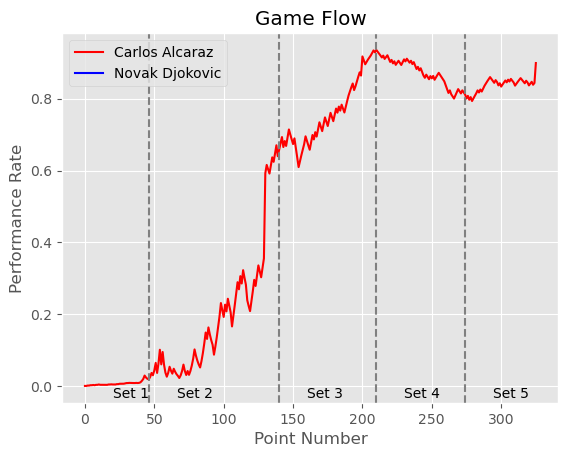

In [14]:
# graph the performance of match flow + momentum
set_change_points = []

old_entry = 1
for index, entry in enumerate(alcaraz_match['set_no']):
    if entry != old_entry:
        set_change_points.append(index + 1)
        old_entry = entry

plt.title("Game Flow")
plt.plot(range(len(p1_momentum1)), p1_momentum1, color="red", label=f"{player1_name}")
plt.plot(range(len(p2_momentum2)), p2_momentum2, color="blue", label=f"{player2_name}")
plt.xlabel("Point Number")
plt.ylabel("Performance Rate")
plt.legend()

plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
for index, value in enumerate(set_change_points):
    plt.axvline(x=value, color='gray', linestyle='--')
    plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

plt.show()

In [34]:
# Find who was performing better before sets 3 and 5
set_change_points = []

old_entry = 1
for index, entry in enumerate(alcaraz_match['set_no']):
    if entry != old_entry:
        set_change_points.append(index + 1)
        old_entry = entry
for index, value in enumerate(set_change_points):
    if index == 1:
        if p1_momentum1[value] > p2_momentum2[value]:
            set_3_pred = player1_name
            print(player1_name, "is winning going into set 3 with: ", p1_momentum1[value], "momentum")
        else:
            set_3_pred = player2_name
            print(player2_name, "is winning going into set 3 with: ", p2_momentum2[value], "momentum")

    if index == 2:
        if p1_momentum1[value] > p2_momentum2[value]:
            set_4_pred = player1_name
            print(player1_name, "is winning going into set 4 with: ", p1_momentum1[value], "momentum")
        else:
            set_4_pred = player2_name
            print(player2_name, "is winning going into set 4 with: ", p2_momentum2[value], "momentum")

    if index == 3:
        if p1_momentum1[value] > p2_momentum2[value]:
            set_5_pred = player1_name
            print(player1_name, "is winning going into set 5 with: ", p1_momentum1[value], "momentum")
        else:
            set_5_pred = player2_name
            print(player2_name, "is winning going into set 5 with: ", p2_momentum2[value], "momentum")


set_victors = alcaraz_match['set_victor']
final_point = set_victors.iloc[-1]
if final_point == 1:
    winner = player1_name
else:
    winner = player2_name
print(winner, "won the game")

if winner == set_4_pred:
    print("set 3 prediction is correct")
else:
    print("set 3 prediction is wrong")

if winner == set_4_pred:
    print("set 4 prediction is correct")
else:
    print("set 4 prediction is wrong")

if winner == set_5_pred:
    print("set 5 prediction is correct")
else:
    print("set 5 prediction is wrong")

Novak Djokovic is winning going into set 3 with:  0.8153147326122672 momentum
Carlos Alcaraz is winning going into set 4 with:  0.9712612465188015 momentum
Carlos Alcaraz is winning going into set 5 with:  0.9161416701271884 momentum
Carlos Alcaraz won the game
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct
